In [1]:
using Plots, Printf, DelimitedFiles, BenchmarkTools, DelimitedFiles, Serialization, Random, Statistics
include("../src/MDToolbox.jl")
using .MDToolbox

In [2]:
q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = readpdb("data/t1r/cluster.pdb");
for iatom = 1:model_array.natom
    model_array.atomname[iatom] = model_array.resname[iatom]
end
MDToolbox.decenter!(model_array)
param_array = [AfmizeConfig(10.0 * (pi / 180),
                            r, 
                            MDToolbox.Point2D(-250, -200), 
                            MDToolbox.Point2D(250, 200), 
                            MDToolbox.Point2D(6.25, 6.25), 
                            MDToolbox.defaultParameters())
                            for r in [15, 20, 25, 30]]

model_num = size(model_array)[1]
q_num = size(q_array)[1]

576

In [3]:
function make_rand_tada(seed_num, sigma, num, detail)
    seed = MersenneTwister(seed_num)
    ret = []
    models = []
    for i in 1:num
        model = model_array[rand(seed, 1:model_num), :]
        radius = rand(seed, 10:30)
        quate = q_array[rand(seed, 1:q_num), :]
        dx = rand(seed, 1:25) * 0.25 * detail
        dy = rand(seed, 1:25) * 0.25 * detail
        config = AfmizeConfig(10.0 * (pi / 180), 
                      radius, 
                      MDToolbox.Point2D(-250 + dx, -200 + dy), 
                      MDToolbox.Point2D(250 + dx, 200 + dy), 
                      MDToolbox.Point2D(6.25, 6.25), 
                      MDToolbox.defaultParameters())
        model = MDToolbox.rotate(model, quate)
        # afm = MDToolbox.afmize(model, config)
        afm = zeros(80, 64)
        h, w = size(afm)
        afm .+= randn(seed, h, w) * sigma
        push!(ret, afm)
        push!(models, model)
    end
    return ret, models
end

make_rand_tada (generic function with 1 method)

In [4]:
seed_nums = [1, 1, 1, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 2, 2, 3, 3, 5]
sigmas = [3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 4, 3, 6, 4, 5, 6, 3, 4, 6]
nums = [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
details = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
all_sample = 20

20

In [5]:
before = []
after = []
best_posteriors = []
sigma_array = []
detail_array = []
for tests in 1:all_sample
    seed_num = seed_nums[tests]
    sigma = sigmas[tests]
    num = nums[tests]
    detail = details[tests]
    
    results = MDToolbox.inputResults("afm_test_seed_$(seed_num)_sigma_$(sigma)_num_$(num)_detail_$(detail).txt");
    afms, test_models = make_rand_tada(seed_num, sigma, num, detail);
    
    for i in 1:size(results)[1]
        result_model = model_array[results[i].best_model_id, :]
        result_model = MDToolbox.rotate(result_model, q_array[results[i].best_quate_id, :])
        push!(before, MDToolbox.getrmsd(result_model, test_models[i])[1])
        result_model = MDToolbox.superimpose(test_models[i], result_model)
        push!(after, MDToolbox.getrmsd(result_model, test_models[i])[1])
        push!(best_posteriors, results[i].best_posterior)
        push!(sigma_array, sigma)
        push!(detail_array, detail)
    end
end

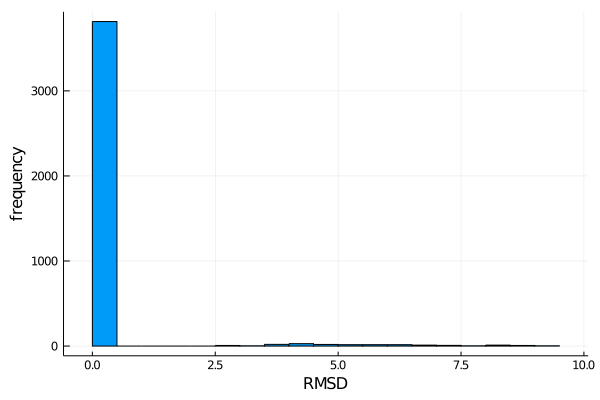

In [6]:
hist = []
for x in before
    if x <= 10
        push!(hist, x)
    end
end
histogram(hist, legend = false, nbins=20)
xlabel!("RMSD")
ylabel!("frequency")

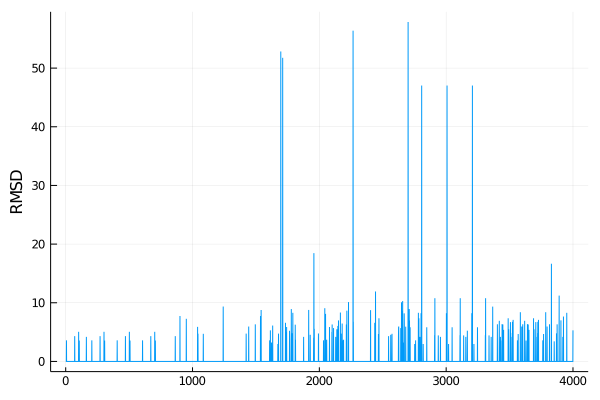

In [7]:
plot(1:200*all_sample, before, legend = false)
ylabel!("RMSD")

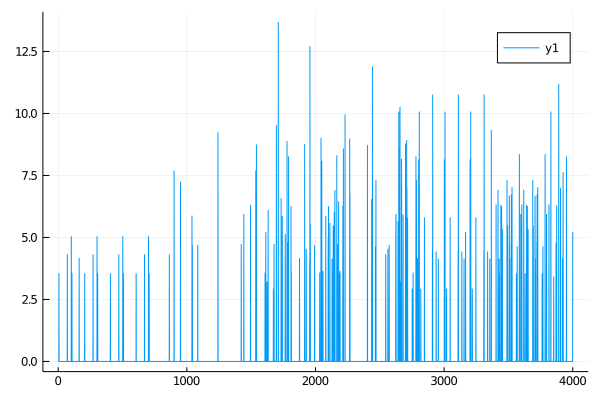

In [8]:
plot(1:200*all_sample, after)

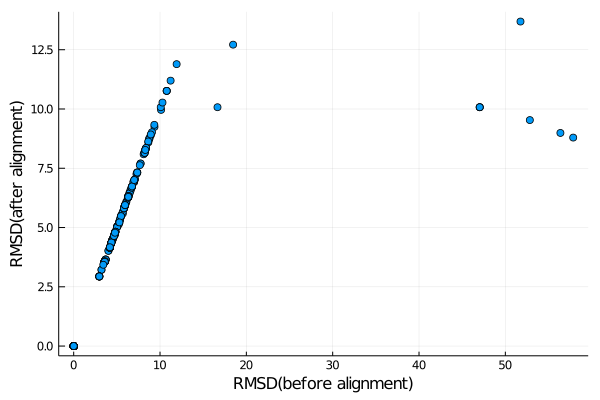

In [9]:
plot(before, after, seriestype = :scatter, legend = false)
xlabel!("RMSD(before alignment)")
ylabel!("RMSD(after alignment)")

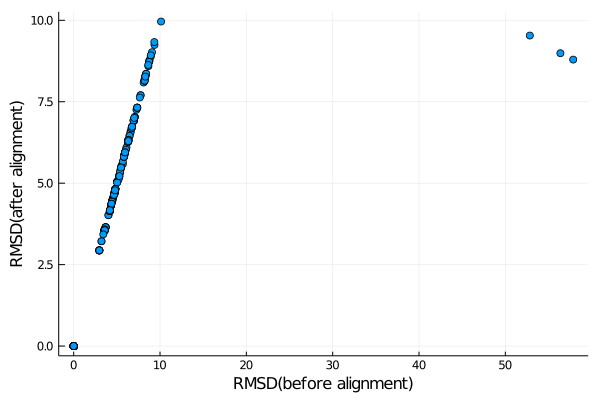

In [10]:
x = []
y = []
for i in 1:size(after)[1]
    if 10 < after[i] continue end
    push!(x, before[i])
    push!(y, after[i])
end

plot(x, y, seriestype = :scatter, legend = false)
xlabel!("RMSD(before alignment)")
ylabel!("RMSD(after alignment)")

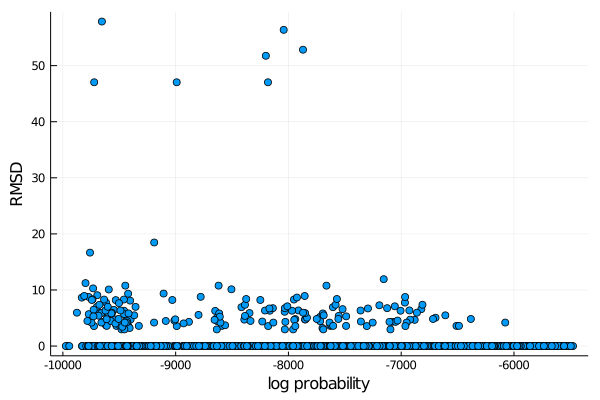

In [11]:
plot(best_posteriors, before, seriestype = :scatter, legend = false)
xlabel!("log probability")
ylabel!("RMSD")

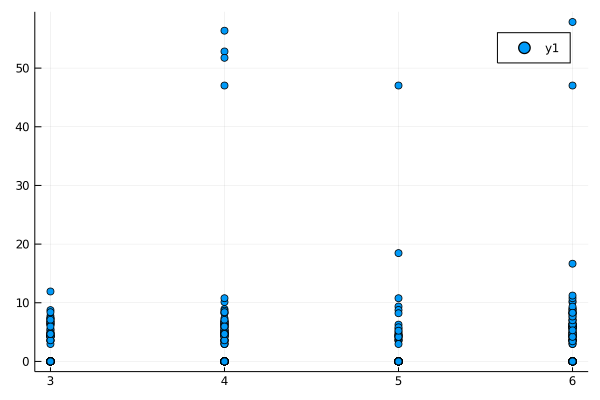

In [12]:
plot(sigma_array, before, seriestype = :scatter)

sigma 3: mean = 0.261426995951593
sigma 3: std = 1.2501444987192079
sigma 4: mean = 0.41585611274904655
sigma 4: std = 3.22261800779832
sigma 5: mean = 0.22417661930267804
sigma 5: std = 2.0072143305621997
sigma 6: mean = 0.4336856701174275
sigma 6: std = 2.6312228443325587


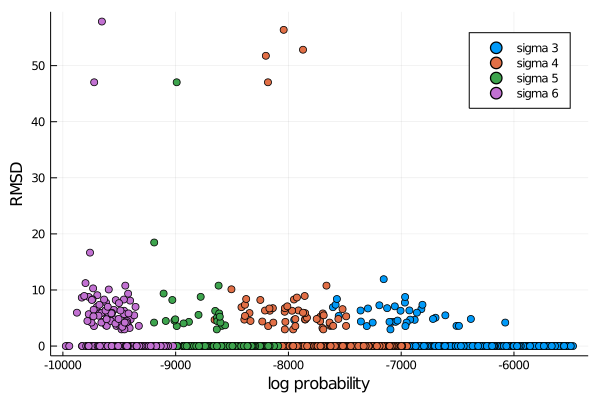

In [13]:
x = []
y = []
for sigma in [3, 4, 5, 6]
    rmsds = []
    posteriors = []
    for i in 1:200*all_sample
        if sigma_array[i] != sigma continue end
        # if detail_array[i] == 0 continue end
        push!(rmsds, before[i])
        push!(posteriors, best_posteriors[i])
    end
    push!(x, posteriors)
    push!(y, rmsds)
    println("sigma $(sigma): mean = $(mean(rmsds))")
    println("sigma $(sigma): std = $(std(rmsds))")
end

plot(x, y, seriestype = :scatter, label = ["sigma 3" "sigma 4" "sigma 5" "sigma 6"])
xlabel!("log probability")
ylabel!("RMSD")

tests = 1
tests = 2
tests = 3
tests = 4
tests = 5
tests = 6
tests = 7
tests = 8
tests = 9
in
52.83621744022766 9.532051910382604
in
51.754642126532225 13.688511653837248
tests = 10
tests = 11
tests = 12
in
56.378494272954924 8.989685298590313
tests = 13
tests = 14
in
57.86060769031094 8.793809256082495
tests = 15
in
47.03066983362836 10.074519760098239
tests = 16
in
47.03066983362836 10.074519760098239
tests = 17
in
47.03066983362836 10.074519760098239
tests = 18
tests = 19
tests = 20


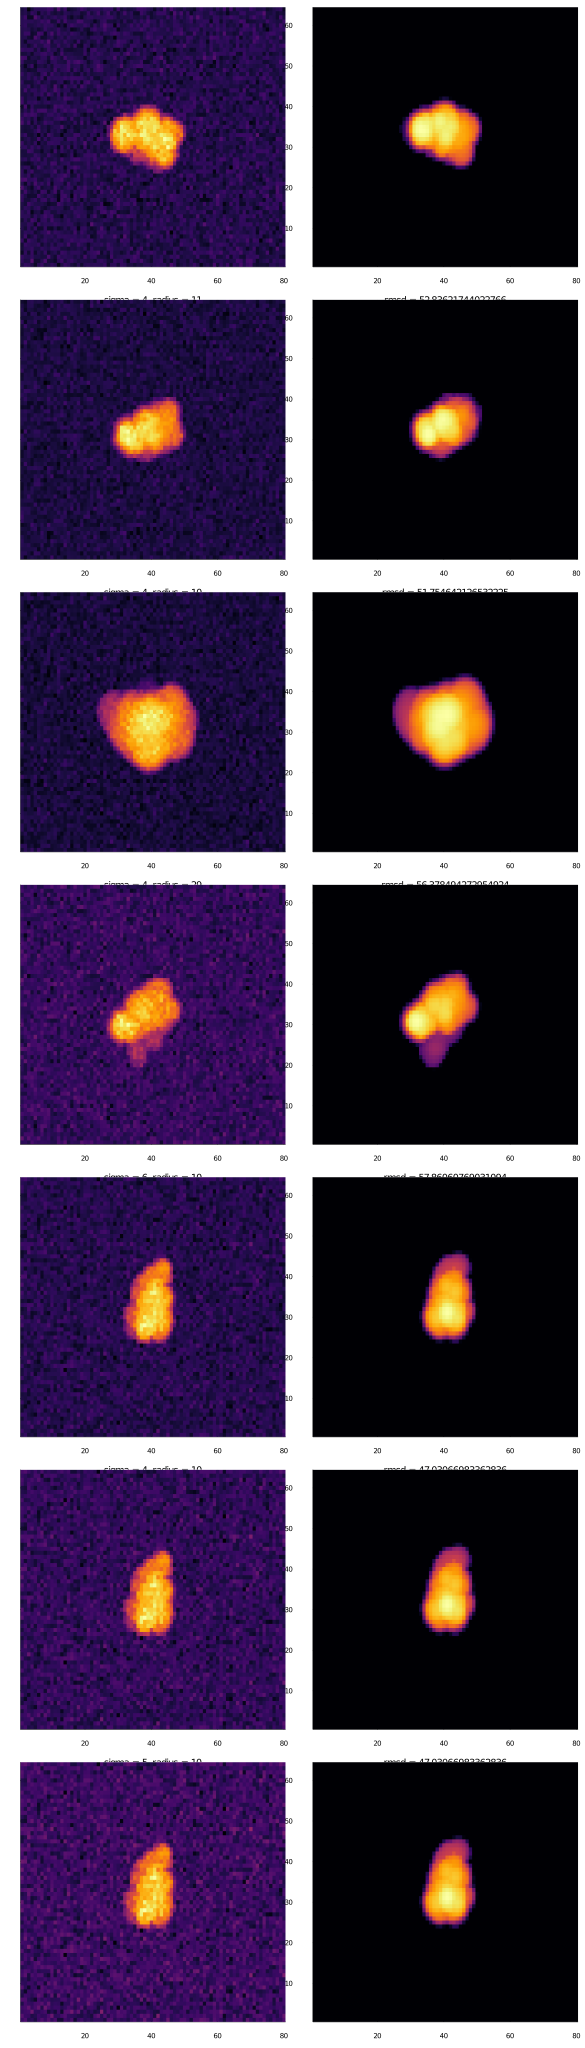

In [14]:
plts = Plots.Plot[]
radius_array = []
cou = 0
for tests in 1:all_sample
    @show tests
    seed_num = seed_nums[tests]
    sigma = sigmas[tests]
    num = nums[tests]
    detail = details[tests]
    
    results = MDToolbox.inputResults("afm_test_seed_$(seed_num)_sigma_$(sigma)_num_$(num)_detail_$(detail).txt");
    seed = MersenneTwister(seed_num)

    for i in 1:num
        model = model_array[rand(seed, 1:model_num), :]
        radius = rand(seed, 10:30)
        quate = q_array[rand(seed, 1:q_num), :]
        dx = rand(seed, 1:25) * 0.25 * detail
        dy = rand(seed, 1:25) * 0.25 * detail
        config = AfmizeConfig(10.0 * (pi / 180), 
                      radius, 
                      MDToolbox.Point2D(-250 + dx, -200 + dy), 
                      MDToolbox.Point2D(250 + dx, 200 + dy), 
                      MDToolbox.Point2D(6.25, 6.25), 
                      MDToolbox.defaultParameters())
        model = MDToolbox.rotate(model, quate)
        afm = zeros(80, 64)
        
        result_model = model_array[results[i].best_model_id, :]
        result_model = MDToolbox.rotate(result_model, q_array[results[i].best_quate_id, :])
        rmsd = MDToolbox.getrmsd(result_model, model)[1]
        if 20 < rmsd
            afm = MDToolbox.afmize(model, config)
        end        
        h, w = size(afm)
        afm .+= randn(seed, h, w) * sigma
        
        if 20 < rmsd
            push!(plts, heatmap(afm, legend = :none, xlabel = "sigma = $(sigma), radius = $(radius)"))
            push!(plts, heatmap(results[i].best_afm, legend = :none, xlabel = "rmsd = $(rmsd)"))
            cou += 1
            println("in")
            writepdb("big_error_model_obs_$(cou).pdb", model)
            writepdb("big_error_model_cal_$(cou).pdb", result_model)
            result_model = MDToolbox.superimpose(model, result_model)
            writepdb("big_error_model_superimposed_$(cou).pdb", result_model)
            after_rmsd = MDToolbox.getrmsd(result_model, model)[1]
            println("$(rmsd) $(after_rmsd)")
        end 
        push!(radius_array, radius)
    end
end

plot(plts..., layout=Plots.GridLayout(cou, 2), size=(1000, 500*cou))

10 mean: 3.4944267063306818
10 std: 8.856728767476621
11 mean: 1.4629872825383352
11 std: 4.475873274720589
12 mean: 0.650149307767483
12 std: 2.091874827720844
13 mean: 0.0822766395852158
13 std: 0.6431088557360883
14 mean: 0.0
14 std: 0.0
15 mean: 0.0
15 std: 0.0
16 mean: 0.09363764842149926
16 std: 0.6306327001789004
17 mean: 0.21931866147042034
17 std: 1.0963658409586772
18 mean: 0.11916827717802113
18 std: 0.7070334980110429
19 mean: 0.08515944110779566
19 std: 0.7589885817032967
20 mean: 0.10022453161835754
20 std: 0.8641597138823303
21 mean: 0.3035975424730508
21 std: 1.3756985278545115
22 mean: 0.21522972865131978
22 std: 1.2846762160130674
23 mean: 0.1820953339663518
23 std: 0.9874091305172863
24 mean: 0.09327300058918743
24 std: 0.7005847821111729
25 mean: 0.03505454781051873
25 std: 0.4557091215367438
26 mean: 0.08283344508389079
26 std: 0.7044439724348559
27 mean: 0.18050055738940382
27 std: 0.9565044014929511
28 mean: 0.12442302228390442
28 std: 0.8855961788993757
29 mean:

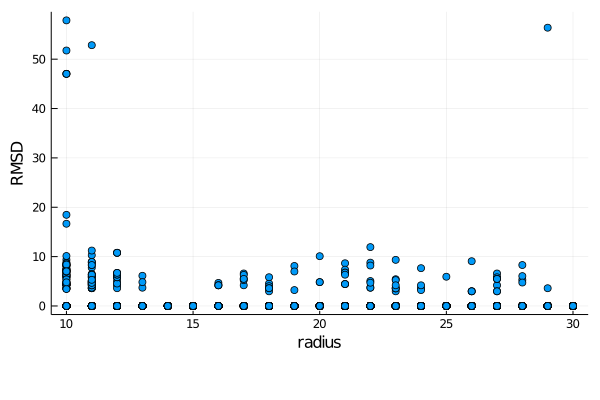

In [15]:
means = []
stds = []
for r in 10:30
    tmp = []
    for i in 1:200*all_sample
        if radius_array[i] != r continue end
        push!(tmp, before[i])
    end
    push!(means, mean(tmp))
    push!(stds, std(tmp))
    println("$(r) mean: $(mean(tmp))")
    println("$(r) std: $(std(tmp))")
end
plot(radius_array, before, seriestype = :scatter, legend = false)
xlabel!("radius")
ylabel!("RMSD")

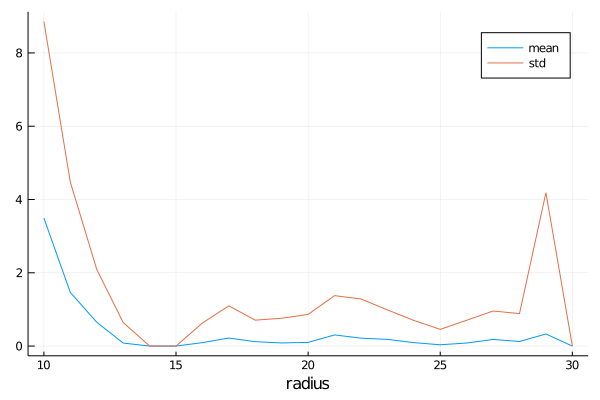

In [16]:
plot(10:30, [means, stds], label = ["mean" "std"])
xlabel!("radius")